    Timestamp  Temperature  Precipitation  Wind Speed  Wind Direction
0  1640995200    48.308952            0.0    4.802906       152.24146
1  1640998800    48.020950            0.0    5.149814       145.61966
2  1641002400    47.732952            0.0    5.061609       135.00000
3  1641006000    46.922950            0.0    4.787252       127.40535
4  1641009600    46.364952            0.0    4.802906       117.75854
The shape of our feature is: (7248, 5)
Wind (Y): [[  4.8029056 152.24146  ]
 [  5.149814  145.61966  ]
 [  5.0616093 135.       ]
 ...
 [  3.2028053 114.77514  ]
 [  3.6138813 111.80141  ]
 [  4.7028894 115.34617  ]]
Columns (X): ['Timestamp', 'Temperature', 'Precipitation']
Training data shape: (5073, 3)
Training labels shape: (5073, 2)
Testing data shape: (2175, 3)
Testing label shape: (2175, 2)
Wait...
Mean Absolute Error: Wind Speed         1.55
Wind Direction    32.31
dtype: float64 degrees.
Accuracy of logistic regression classifier on test set: 0.70


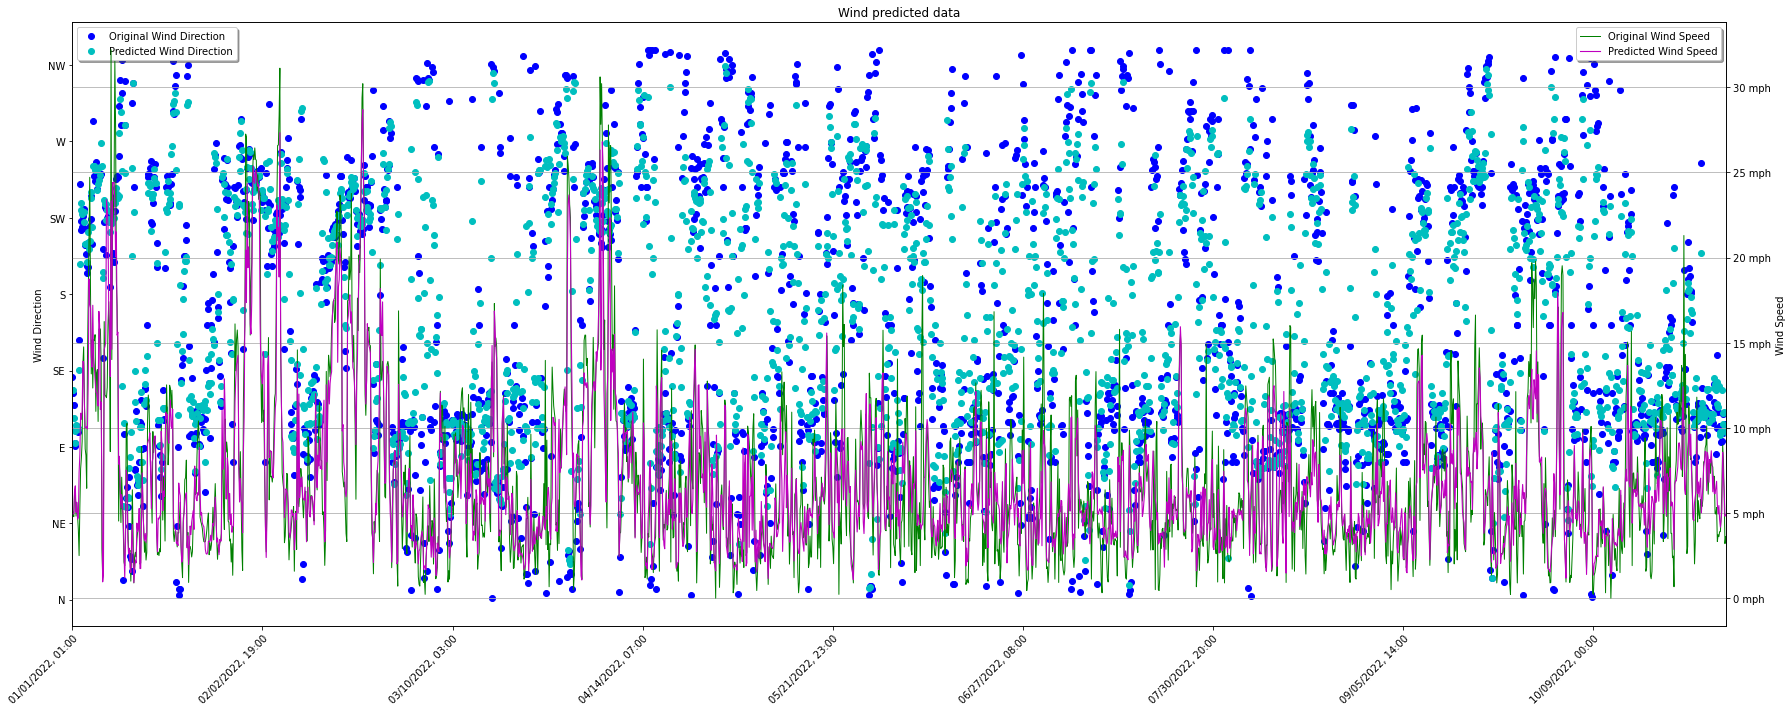

In [2]:
import urllib.request
urllib.request.urlretrieve('https://raw.githubusercontent.com/dgofman/PythonAI/main/AI-Final/dataexport_20221029T025321.csv', '/content/dataexport_20221029T025321.py')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker

from math import floor
from time import mktime
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

epoc = lambda t : int(mktime(datetime.strptime(t, "%Y%m%dT%H%M%S").timetuple()))
data = pd.read_csv('/content/dataexport_20221029T025321.py', sep=',', converters={'Timestamp': epoc})

print(data.head(5))
print('The shape of our feature is:', data.shape)
data.describe()

data = pd.get_dummies(data)
data.head(5)

labels = data[['Wind Speed', 'Wind Direction']]
data = data.drop('Wind Speed', axis=1)
data = data.drop('Wind Direction', axis=1)
data_list = list(data.columns)
print('Wind (Y):', labels.values)
print('Columns (X):', data_list)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.30,random_state=4)

print('Training data shape:', X_train.shape)
print('Training labels shape:', y_train.shape)
print('Testing data shape:', X_test.shape)
print('Testing label shape:', y_test.shape)
rf = RandomForestRegressor(n_estimators=1000, random_state=4)
print('Wait...')
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)
errors = abs(predictions - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(rf.score(X_test, y_test)))

# Visualising the Random Forest Regression results

# sort values begin
order_list= []
keys = X_test['Timestamp'].keys()
for i, k in enumerate(keys):
    order_list.append({'index': i, 'value': k})
order_list = sorted(order_list, key=lambda item: item['value'])

x_values = []
y1_values = []
y2_values = []
y3_values = []
y4_values = []
for item in order_list:
    index = item['index']
    x_values.append(X_test['Timestamp'].values[index])
    y1_values.append(y_test['Wind Speed'].values[index])
    y2_values.append(y_test['Wind Direction'].values[index])
    y3_values.append(predictions[index][0])
    y4_values.append(predictions[index][1])
# sort values end

def format(x, _):
    index = int(x)
    if index < len(x_values):
        ts = x_values[index]
    else:
        ts = x_values[-1]
    return datetime.fromtimestamp(ts).strftime('%m/%d/%Y, %H:%M')

def compasValue(y):
    return compass[y - (y % 45)] if y > 45 else 'N'

def cursor_annotations(sel):
    sel.annotation.get_bbox_patch().set(alpha=0.9)
    sel.annotation.set(
                    text=sel.artist.get_label() + '\nTimestamp:' + 
                    datetime.fromtimestamp(x_values[floor(sel.target[0])]).strftime('%m/%d/%Y, %H:%M') +
                    ('\nWind Speed: {:.0f} mph'.format(sel.target[1]) if 'Speed' in sel.artist.get_label() else
                    '\nWind Direction: {}'.format(compasValue(sel.target[1]))))
    

length = len(x_values)
x_ax = range(length)
fig, ax = plt.subplots(figsize = (25, 10))
ax2 = ax.twinx()
plt.xlim(0, length)
plt.title('Wind predicted data')
plt.xlabel('Timestamp')

ax.set_ylabel('Wind Direction')
ax.plot(x_ax, y2_values, 'bo', linewidth=1, label='Original Wind Direction')
ax.plot(x_ax, y4_values, 'co', linewidth=1.1, label='Predicted Wind Direction')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{}'.format(compasValue(y))))

ax2.set_ylabel('Wind Speed')
ax2.plot(x_ax, y1_values, '-g', linewidth=1, label='Original Wind Speed')
ax2.plot(x_ax, y3_values, '-m', linewidth=1.1, label='Predicted Wind Speed')
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0f} mph'.format(y)))

ax2.legend(loc=1, fancybox=True, shadow=True)
ax.legend(loc=2, fancybox=True, shadow=True)

compass = {
    0: 'N', 45: 'NE', 90: 'E', 135: 'SE', 180: 'S', 225: 'SW', 270: 'W', 315: 'NW', 360: 'N'
}
ticks_loc = ax.get_xticks()
ax.xaxis.set_major_locator(ticker.FixedLocator(ticks_loc))
ax.set_xticklabels(ticks_loc, rotation=45, ha='right', rotation_mode='anchor')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format))

plt.grid(True)
plt.tight_layout()